In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [16]:
fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms())

In [17]:
dls = fields.dataloaders('../input/brain-tumor-classification-mri')

In [18]:
dls.vocab

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

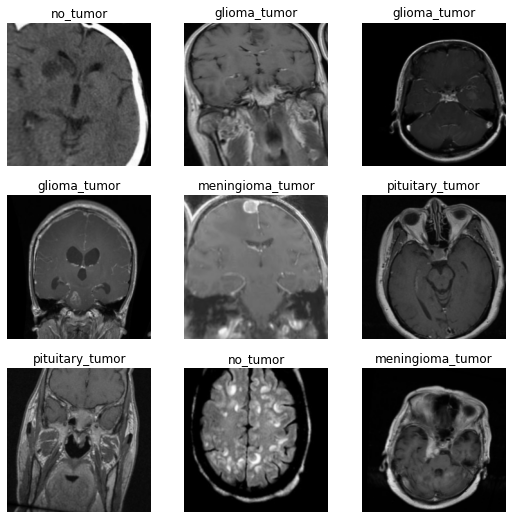

In [19]:
dls.show_batch()

In [20]:
learn = vision_learner(dls,resnet152,metrics = [accuracy,error_rate])

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [21]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.288351,1.346925,0.641104,0.358896,01:02


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.674251,0.525014,0.869632,0.130368,01:11


SuggestedLRs(valley=0.0003311311302240938)

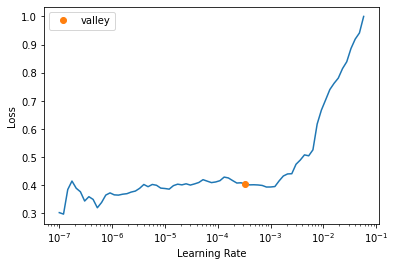

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(4,6e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.326282,0.258561,0.930982,0.069018,01:15
1,0.252059,0.255568,0.929448,0.070552,01:16
2,0.188465,0.177902,0.955521,0.044479,01:18
3,0.139996,0.166762,0.953988,0.046012,01:17


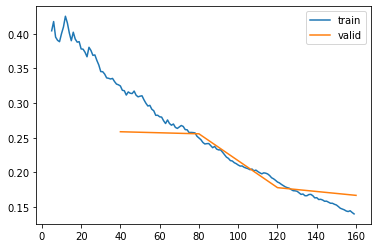

In [24]:
learn.recorder.plot_loss()

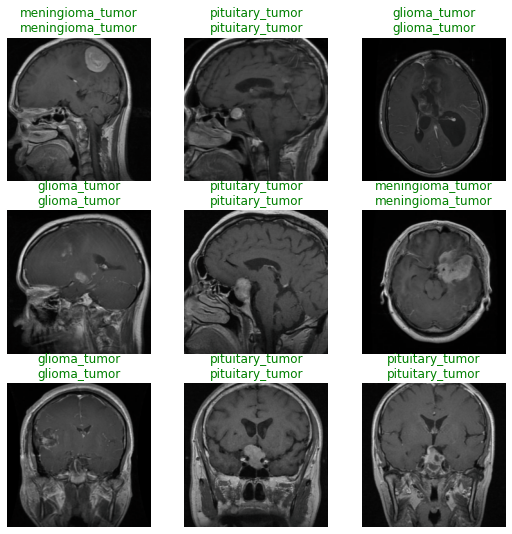

In [25]:
learn.show_results()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(4,lr_max=slice(1e-5,6e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.096763,0.184758,0.944785,0.055215,01:15
1,0.097814,0.194920,0.941718,0.058282,01:16
2,0.088755,0.183954,0.949386,0.050613,01:15
3,0.073971,0.164853,0.953988,0.046012,01:15


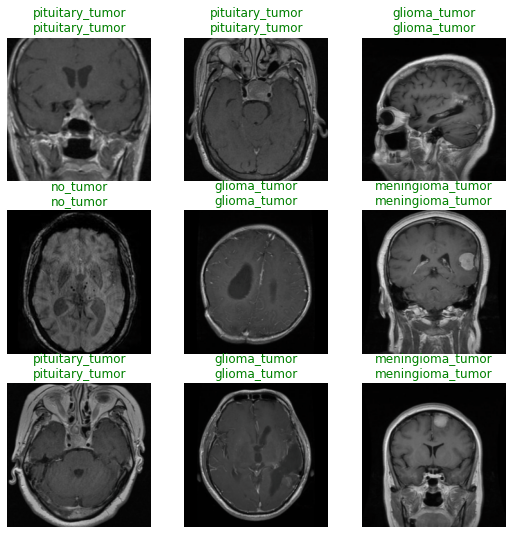

In [27]:
learn.show_results()

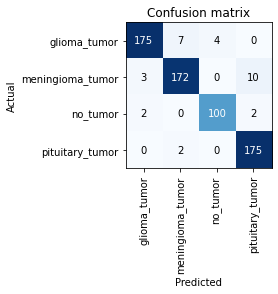

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

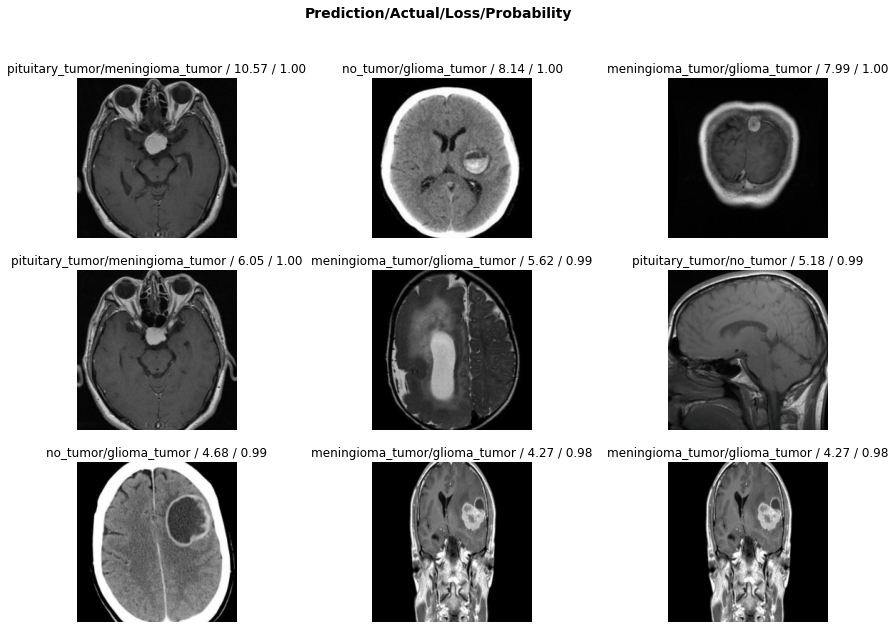

In [29]:
interp.plot_top_losses(9, figsize=(15,10))

In [30]:
learn.export()

In [31]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

In [32]:
learn.predict(path/'../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(1).jpg')

('glioma_tumor',
 TensorBase(0),
 TensorBase([9.9997e-01, 1.4978e-05, 8.6843e-06, 2.5954e-06]))

In [33]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [34]:
VBox([widgets.Label('Select your MRI'),btn_upload, btn_run, out_pl, lbl_pred])